# Importing needed libraries

In [43]:
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from hyperopt import hp, fmin, tpe, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_regression

# Loading dataset

In [44]:
df = pd.read_csv('harddrive/harddrive.csv')
print(df.shape)
df.head()

(3179295, 95)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,108.0,143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,NaN,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df = df.loc[:, ~df.isnull().all()]
print(df.shape)

(3179295, 91)


In [46]:
# number of hdd
print("number of hdd:", df['serial_number'].value_counts().shape) 

# number of different types of harddrives
print("number of different harddrives", df['model'].value_counts().shape)

number of hdd: (65993,)
number of different harddrives (69,)


In [47]:
failed_hdds = df.loc[df.failure==1]["serial_number"]
len(failed_hdds)

215

In [48]:
df = df.loc[df["serial_number"].isin(failed_hdds)]
df.shape

(5490, 91)

# Finding the RUL (Remaining Useful Life)

In [49]:
df["end_date"] = df.groupby("serial_number")["date"].transform("max")

In [50]:
df["end_date"] = pd.to_datetime(df["end_date"])
df["date"] = pd.to_datetime(df["date"])

In [51]:
df["date_diff"] = df["end_date"] - df["date"]
df["date_diff"].describe()

count                          5490
mean     49 days 09:18:25.573770492
std      44 days 09:17:21.395230515
min                 0 days 00:00:00
25%                 7 days 00:00:00
50%                21 days 00:00:00
75%                95 days 00:00:00
max               119 days 00:00:00
Name: date_diff, dtype: object

In [52]:
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,end_date,date_diff
376,2016-01-01,Z300ZST1,ST4000DM000,1.976651e-311,0,120,240872800,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-17,16 days
1657,2016-01-01,9VY8TCAV,ST3160318AS,7.907120e-313,0,111,38605541,NaN,NaN,97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-09,99 days
1895,2016-01-01,W300BG0H,ST4000DM000,1.976651e-311,0,118,190147064,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-18,108 days
2900,2016-01-01,W300J6FX,ST4000DM000,1.976651e-311,0,115,85258376,NaN,NaN,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-09,99 days
3204,2016-01-01,Z3014A4S,ST4000DM000,1.976651e-311,0,116,101976792,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-10,9 days


In [53]:
df.isnull().sum()

date                       0
serial_number              0
model                      0
capacity_bytes             0
failure                    0
                        ... 
smart_252_raw           4973
smart_254_normalized    4921
smart_254_raw           4921
end_date                   0
date_diff                  0
Length: 93, dtype: int64

In [54]:
df = df.withColumnRenamed("smart_5_normalized","REAllOCATED_SECTOR_COUNT_N") \
    .withColumnRenamed("smart_187_normalized","REPORTED_UNCORRECTABLE_ERRORS_N")\
    .withColumnRenamed("smart_188_normalized","COMMAND_TIMEOUT_N")\
    .withColumnRenamed("smart_197_normalized","CURRENT_PENDING_SECTOR_COUNT_N")\
    .withColumnRenamed("smart_198_normalized","OFFLINE_UNCORRECTABLE_N")\
    .withColumnRenamed("smart_9_normalized","POWER_ON_HOURS_N")\
    .withColumnRenamed("smart_5_raw","REAllOCATED_SECTOR_COUNT_R")\
    .withColumnRenamed("smart_187_raw","REPORTED_UNCORRECTABLE_ERRORS_R")\
    .withColumnRenamed("smart_188_raw","COMMAND_TIMEOUT_R")\
    .withColumnRenamed("smart_197_raw","CURRENT_PENDING_SECTOR_COUNT_R")\
    .withColumnRenamed("smart_198_raw","OFFLINE_UNCORRECTABLE_R")\
    .withColumnRenamed("smart_9_raw","POWER_ON_HOURS_R")\
    .withColumnRenamed("date","DATE")\
    .withColumnRenamed("serial_number","SERIAL_NUMBER")\
    .withColumnRenamed("model","MODEL")\
    .withColumnRenamed("capacity_bytes","CAPACITY_BYTES")\
    .withColumnRenamed("failure","FAILURE").cache()

AttributeError: 'DataFrame' object has no attribute 'withColumnRenamed'

In [ ]:
df[df["serial_number"]=='Z300ZST1'].shape

# Getting rid of NaN values

In [ ]:
df_notna = df[df.columns[~(df.isna().sum().values/len(df) > 0.05)]]

In [ ]:
df_notna.dropna(inplace=True)

In [ ]:
df = df_notna.copy()

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.isnull().sum()

In [ ]:
df.head()

# Dropping unwanted columns, Splitting Data and Training Model

In [ ]:
df = df.drop(['date', 'serial_number', 'model','end_date'], axis=1)
df.head()

In [ ]:
Y = df["date_diff"].dt.days
X = df.drop(["date_diff"],axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have your features in X and target variable in y
# Replace this with your actual data

# Perform train-test split (adjust test_size and random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shapes of the resulting splits
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)


# Random Forest Without Hyper Parameter Tuning

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Creating Random Forest Regressor
RF_model = RandomForestRegressor(random_state=1)
RF_model.fit(X_train, y_train)

# Predicting on test data
y_pred_RF = RF_model.predict(X_test)

# Calculating Mean Squared Error
mse_RF = mean_squared_error(y_test, y_pred_RF)
print("Random Forest MSE:", mse_RF)

# Calculating R^2 score
score_RF = RF_model.score(X_test, y_test)
print("Random Forest R^2 score:", score_RF)

# Visualizing Actual vs Predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_RF, alpha=0.5, label='Predicted', color='blue')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.legend()
plt.show()

# Decision Tree Without HyperParameter Tuning

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Creating Decision Tree Regressor
DT_model = DecisionTreeRegressor(random_state=1)
DT_model.fit(X_train, y_train)

# Predicting on test data
y_pred_DT = DT_model.predict(X_test)

# Calculating Mean Squared Error
mse_DT = mean_squared_error(y_test, y_pred_DT)
print("Decision Tree MSE:", mse_DT)

# Calculating R^2 score
score_DT = DT_model.score(X_test, y_test)
print("Decision Tree R^2 score:", score_DT)

# Visualizing Actual vs Predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_DT, alpha=0.5, label='Predicted', color='green')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Decision Tree)')
plt.legend()
plt.show()


# Random Forest Parameter Tuning With Hyperopt

In [ ]:
seed=2
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    model=RandomForestRegressor(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    score=mean_squared_error(y_test,pred)
    return score

def optimize(trial):
    params={'n_estimators':hp.uniform('n_estimators',10,100),
           'max_depth':hp.uniform('max_depth',5,20),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
           'min_samples_split':hp.uniform('min_samples_split',2,6)}
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=150,rstate=np.random.default_rng(seed=2))
    return best

trial=Trials()
best=optimize(trial)

100%|██████████| 150/150 [03:35<00:00,  1.44s/trial, best loss: 50.08736312896588]


In [ ]:
print(best)

for t in trial.trials[:2]:
    print (t)

{'max_depth': 19.17215985972766, 'min_samples_leaf': 1.8941908452291838, 'min_samples_split': 3.466278351816532, 'n_estimators': 41.428445920019556}
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 107.26788605021952, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [0], 'min_samples_leaf': [0], 'min_samples_split': [0], 'n_estimators': [0]}, 'vals': {'max_depth': [17.06974354546972], 'min_samples_leaf': [2.3918730381022115], 'min_samples_split': [2.9289857075688754], 'n_estimators': [65.86711620344198]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 4, 3, 13, 5, 52, 345000), 'refresh_time': datetime.datetime(2024, 4, 3, 13, 5, 54, 396000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 661.747143699321, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [1], 'min_samples_leaf': [1], 'mi

In [ ]:
TID=[t['tid'] for t in trial.trials]
Loss=[t['result']['loss'] for t in trial.trials]
maxd=[t['misc']['vals']['max_depth'][0] for t in trial.trials]
nest=[t['misc']['vals']['n_estimators'][0] for t in trial.trials]
min_ss=[t['misc']['vals']['min_samples_split'][0] for t in trial.trials]
min_sl=[t['misc']['vals']['min_samples_leaf'][0] for t in trial.trials]

hyperopt_rfr=pd.DataFrame({'tid':TID,'loss':Loss,
                          'max_depth':maxd,'n_estimators':nest,
                          'min_samples_split':min_ss, 'min_samples_leaf':min_sl})

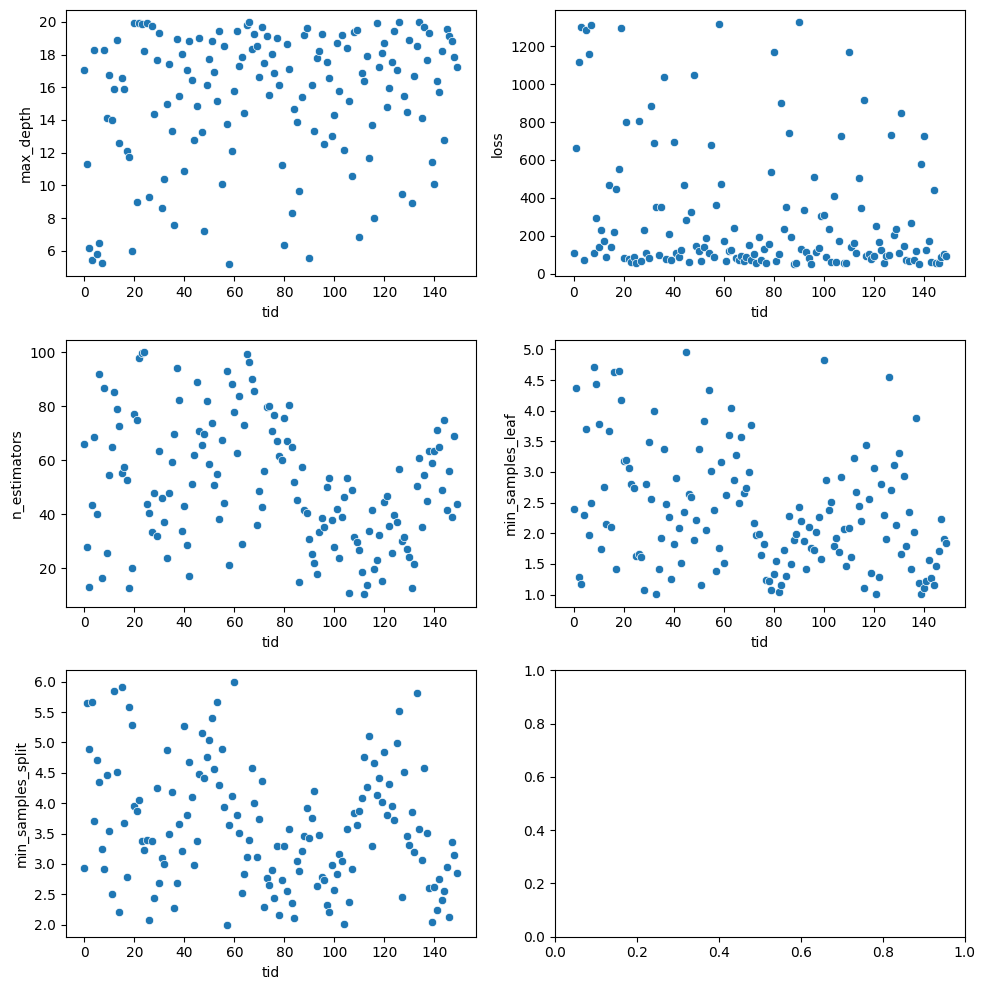

In [ ]:
plt.subplots(3,2,figsize=(10,10))
plt.subplot(3,2,1)
sns.scatterplot(x='tid',y='max_depth',data=hyperopt_rfr)
plt.subplot(3,2,2)
sns.scatterplot(x='tid',y='loss',data=hyperopt_rfr)
plt.subplot(3,2,3)
sns.scatterplot(x='tid',y='n_estimators',data=hyperopt_rfr)
plt.subplot(3,2,4)
sns.scatterplot(x='tid',y='min_samples_leaf',data=hyperopt_rfr)
plt.subplot(3,2,5)
sns.scatterplot(x='tid',y='min_samples_split',data=hyperopt_rfr)

plt.tight_layout()

In [ ]:
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'min_samples_split': int(best['min_samples_split']),
    'random_state': 2  # Assuming you want to set the random state
}

rfr_opt = RandomForestRegressor(**best_params)
rfr_opt.fit(X_train,y_train)
pred_rfr_opt=rfr_opt.predict(X_test)
score_rfr_opt=mean_squared_error(y_test,pred_rfr_opt)
score = rfr_opt.score(X_test, y_test)
print("MSE Random Forest After HyperParameter Tuning With Hyperopt: ", score_rfr_opt)
print("R^2 Score Random Forest After Hyperparameter Tuning With Hyperopt: ", score)

MSE Random Forest After HyperParameter Tuning With Hyperopt:  59.85501980869229
R^2 Score Random Forest After Hyperparameter Tuning With Hyperopt:  0.9700304898381196


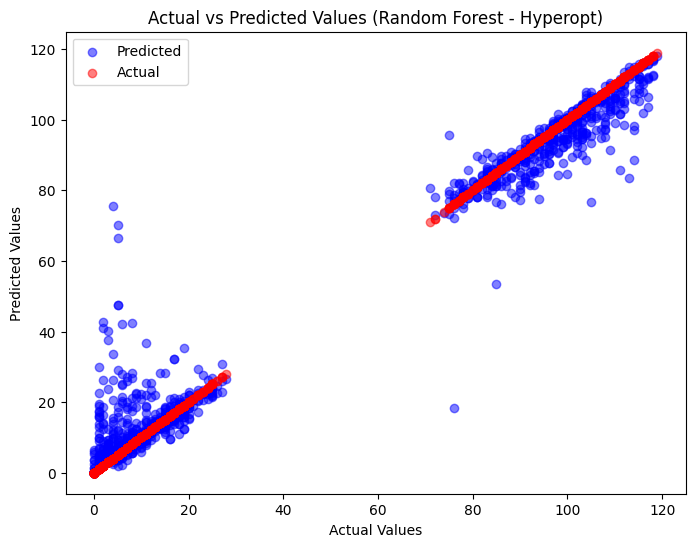

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_rfr_opt, alpha=0.5, label='Predicted', color='blue')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest - Hyperopt)')
plt.legend()
plt.show()